In [8]:
from tensorflow.keras.datasets import mnist

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

In [10]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [13]:
X_train = X_train.reshape(-1, 28 * 28).astype(np.float32)
X_test = X_test.reshape(-1, 28 * 28).astype(np.float32)
print(X_train.shape)
print(X_test.shape)

(60000, 784)
(10000, 784)


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

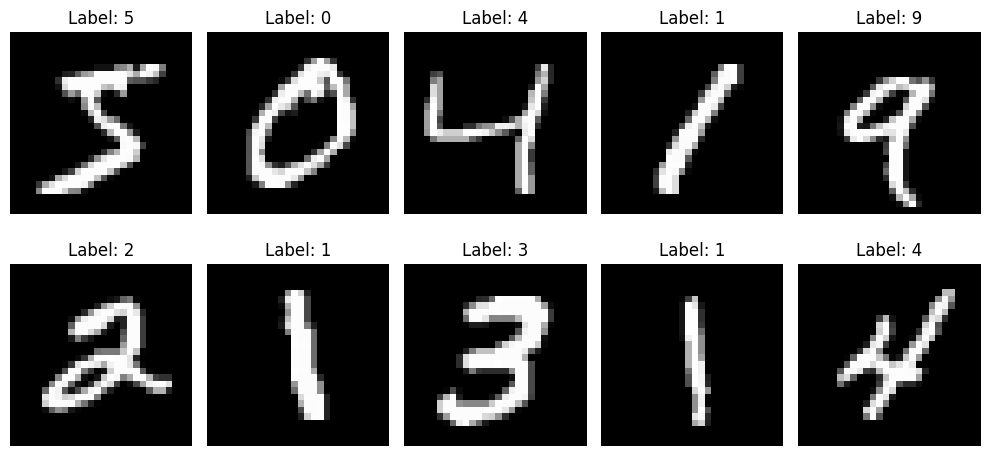

In [17]:
fig, axes = plt.subplots(2, 5, figsize=(10,5))
for i, ax in enumerate(axes.ravel()):
  ax.imshow(X_train[i].reshape(28, 28), cmap='gray')
  ax.set_title(f"Label: {y_train[i]}")
  ax.axis('off')

plt.tight_layout()
plt.show()

In [18]:
classifier = LinearSVC(dual=False, max_iter=10)

In [19]:
classifier.fit(X_train_scaled, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=False, max_iter=10)

In [20]:
y_pred = classifier.predict(X_test_scaled)

In [21]:
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")

Accuracy = 0.9166


In [22]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.95      0.98      0.96      1135
           2       0.93      0.88      0.91      1032
           3       0.90      0.91      0.90      1010
           4       0.91      0.93      0.92       982
           5       0.88      0.87      0.87       892
           6       0.93      0.95      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.85      0.87       974
           9       0.90      0.89      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



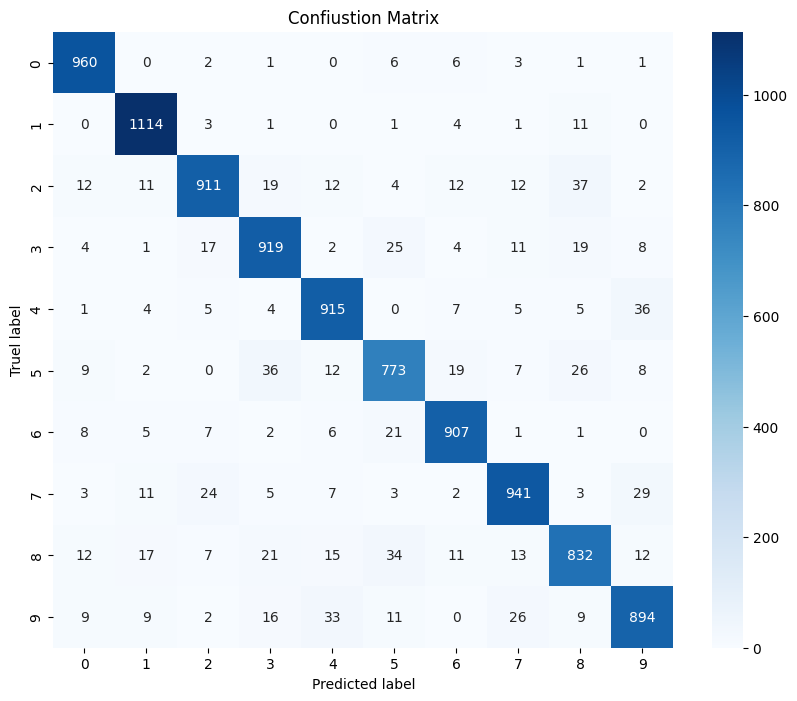

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted label")
plt.ylabel("Truel label")
plt.title("Confiustion Matrix")
plt.show()

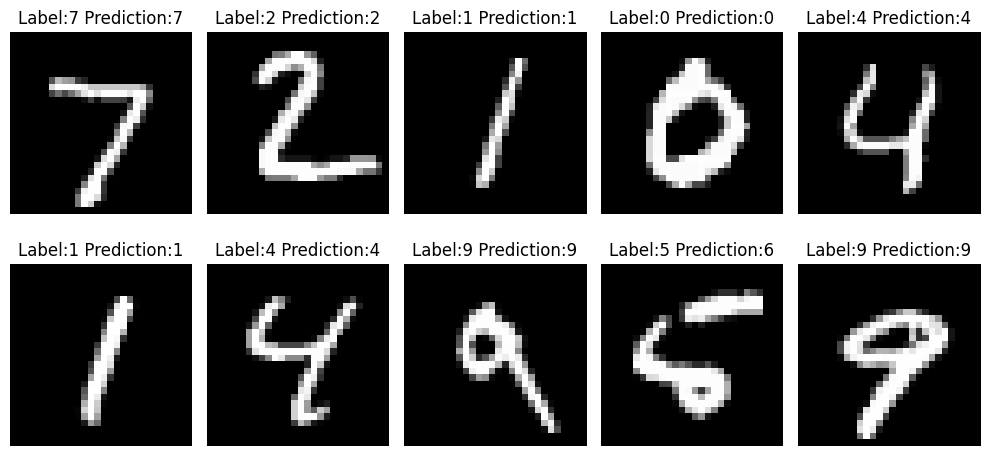

In [26]:
fig, axes = plt.subplots(2, 5, figsize=(10,5))
for i, ax in enumerate(axes.ravel()):
  ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
  ax.set_title(f"Label:{y_test[i]} Prediction:{y_pred[i]}")
  ax.axis('off')

plt.tight_layout()
plt.show()

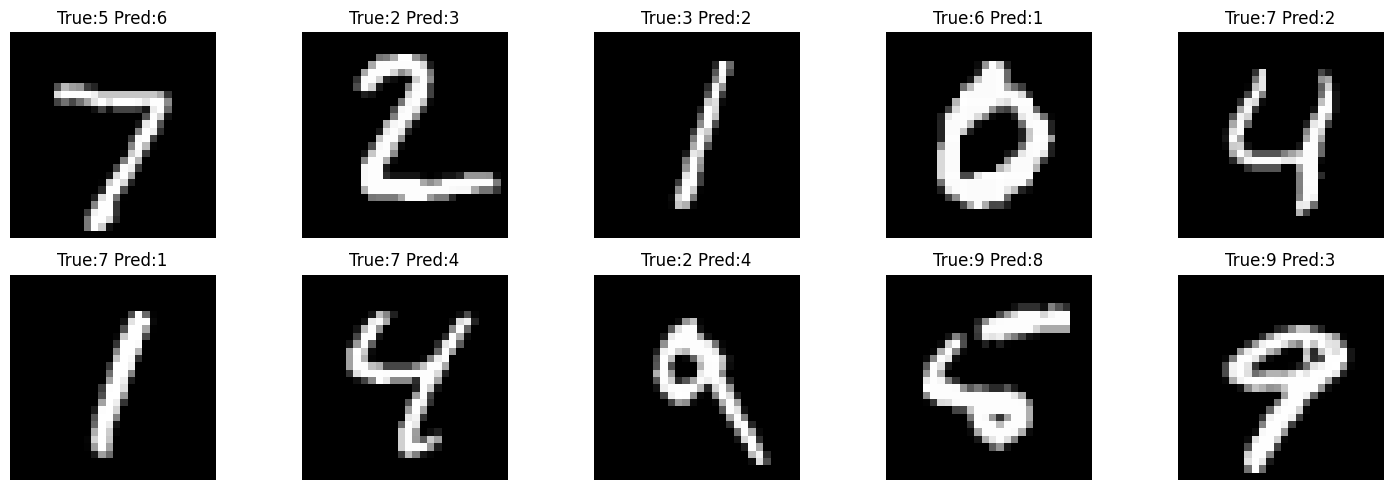

In [28]:
misclassified_indices = np.where(y_test != y_pred)[0]

plt.figure(figsize=(15, 5))

for i, index in enumerate(misclassified_indices[:10]):
  plt.subplot(2, 5, i+1)
  plt.imshow(X_test[i].reshape(28, 28), cmap='gray')
  plt.title(f"True:{y_test[index]} Pred:{y_pred[index]}")
  plt.axis('off')

plt.tight_layout()
plt.show()

In [41]:
weights = classifier.coef_
bias = classifier.intercept_
print(weights.shape)
print(bias.shape)

(10, 784)
(10,)


In [60]:
max_val = np.abs(weights).max()
w_scale = max_val / 127.0
weights_int8 = np.round(weights / w_scale).astype(np.int8)

max_bias = np.abs(bias).max()
b_scale = max_bias / 127.0
bias_int8 = np.round(bias / b_scale).astype(np.int8)

with open("svm_model.h", "w") as f:
  f.write(f"#include <stdint.h>\n\n")
  f.write(f"#define NUM_CLASSES {weights.shape[0]}\n")
  f.write(f"#define NUM_FEATURES {weights.shape[1]}\n\n")
  f.write(f"const float weight_scale = {w_scale:.10f}f;\n")
  f.write(f"const float bias_scale = {b_scale:.10f}f;\n\n")

  f.write("int8_t weights[NUM_CLASSES][NUM_FEATURES] = {\n")
  for row in weights_int8:
    f.write("   {" + ", ".join(str(v) for v in row) + "},\n")
  f.write("};\n\n")

  f.write("float bias[NUM_CLASSES] = {" + ", ".join(str(b) for b in bias_int8) + "};\n")

print("Exported SVM Model to svm_model.h")

Exported SVM Model to svm_model.h


In [59]:
mean = scaler.mean_
max_mean = np.abs(mean).max()
m_scale = max_mean / 127.0
mean_int8 = np.round(mean / m_scale).astype(np.int8)

op_scale = scaler.scale_
max_scale = np.abs(op_scale).max()
s_scale = max_scale / 127.0
scale_int8 = np.round(op_scale / s_scale).astype(np.int8)

with open("scaler.h", "w") as f:
  f.write(f"#include <stdint.h>\n\n")
  f.write(f"#define NUM_FEATURES {len(mean)}\n\n")
  f.write(f"const float mean_scale = {m_scale:.10f}f;\n")
  f.write(f"const float scale_scale = {s_scale:.10f}f;\n\n")

  f.write("int8_t mean[NUM_FEATURES] = {\n")
  f.write("   " + ", ".join(str(m) for m in mean_int8) + "\n};\n\n")

  f.write("int8_t scale[NUM_FEATURES] = {\n")
  f.write("   " + ", ".join(str(s) for s in scale_int8) + "\n};\n\n")

print("Exported scalar parameters to scaler.h")

Exported scalar parameters to scaler.h


In [34]:
NUM_IMAGES_TO_EXPORT = 10
assert X_test.shape[1] == 784
X_sample = X_test[:NUM_IMAGES_TO_EXPORT]
y_sample = y_test[:NUM_IMAGES_TO_EXPORT]

In [48]:
def export_test_images_to_c(images, labels, filename="test_images.h"):
  num_images, num_features = images.shape
  images_int8 = images.astype(np.int8)
  with open(filename, "w") as f:
    f.write("#ifndef TEST_IMAGES_H\n#define TEST_IMAGES_H\n\n")
    f.write(f"#include <stdint.h>\n\n")
    f.write(f"#define NUM_TEST_IMAGES {num_images}\n")
    f.write(f"#define NUM_FEATURES {num_features}\n\n")

    # Write image data
    f.write(f"int8_t test_images[NUM_TEST_IMAGES][NUM_FEATURES] = {{\n")
    for img in images_int8:
      f.write("   {" + ", ".join(str(px) for px in img) + "},\n")
    f.write(" };\n\n")

    # Write labels as integers
    f.write(f"int test_labels[NUM_TEST_IMAGES] = {{ ")
    f.write(", ".join(str(label) for label in labels))
    f.write("};\n\n")

    f.write("#endif // TEST_IMAGES_H")

  print(f"Exported {num_images} test images to {filename}")

In [49]:
export_test_images_to_c(X_sample, y_sample, "test_images.h")

Exported 10 test images to test_images.h
